In [4]:
import numpy as np
import pandas as pd

import os

import matplotlib  as mpl
import matplotlib.pyplot as plt

import cv2

%matplotlib inline
# Optionally, tweak styles.
mpl.rc('figure',  figsize=(22*1.5, 12*1.5))
mpl.rc('image', cmap='gray')

2000.jpg


Text(0,0.5,'y')

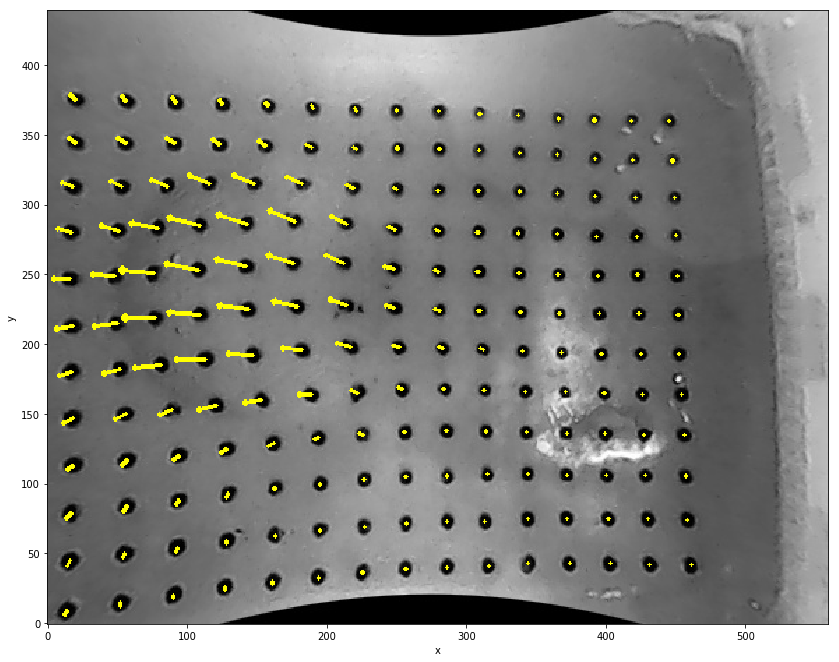

In [5]:
csv_path = '../dataset2/csv'
img_path = '../dataset2/images'

# plt.figure(figsize=(30, 30))

# count = 0
# for filename in os.listdir(csv_path)[:10]:
#     ind = filename.split('.')[0]
#     image_name = ind + '.jpg'
#     image_file = os.path.join(img_path, image_name)
#     csv_file = os.path.join(csv_path, filename)
# #     print image_path
#     # read in the csv and image
#     df = pd.read_csv(csv_file)
#     img = plt.imread(image_file)
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#     # draw arrows on images
# #     print df
#     x = df['x']
#     y = df['y']
#     xt = df['xt']
#     yt = df['yt']
#     print image_name
#     for i in range(0, len(df)):
#         cv2.arrowedLine(img_rgb, (int(np.around(x[i])), int(np.around(y[i]))),
#                         (int(np.around(xt[i])), int(np.around(yt[i]))),
#                         (255, 255, 0),
#                         thickness=2)

#     plt.subplot(5, 2, count+1)
#     plt.imshow(img_rgb, origin='lower')
#     plt.xlabel('x')
#     plt.ylabel('y')

#     count += 1

plt.figure(figsize=(14, 14))

filename = '2000.csv'
image_name = '2000.jpg'

image_file = os.path.join(img_path, image_name)
csv_file = os.path.join(csv_path, filename)
#     print image_path
# read in the csv and image
df = pd.read_csv(csv_file)
img = plt.imread(image_file)
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
# draw arrows on images
#     print df
x = df['x']
y = df['y']
xt = df['xt']
yt = df['yt']
print image_name
for i in range(0, len(df)):
    cv2.arrowedLine(img_rgb, (int(np.around(x[i])), int(np.around(y[i]))),
                    (int(np.around(xt[i])), int(np.around(yt[i]))),
                    (255, 255, 0),
                    thickness=2)

plt.subplot(1, 1, 1)
plt.imshow(img_rgb, origin='lower')
plt.xlabel('x')
plt.ylabel('y')

In [6]:
from scipy.interpolate import Rbf
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline


img_interp_path = '../dataset2/interpolation/images'
contour_dx_path = '../dataset2/interpolation/contour/dx'
contour_dy_path = '../dataset2/interpolation/contour/dy'
contour_mag_path = '../dataset2/interpolation/contour/mag'

vec_interp_path = '../dataset2/interpolation/vectors'

plt.figure(figsize=(40,40))
count = 0
for filename in os.listdir(csv_path)[100]:
    ind = filename.split('.')[0]
    image_name = ind + '.jpg'
    image_file = os.path.join(img_path, image_name)
    csv_file = os.path.join(csv_path, filename)
#     print image_path
    # read in the csv and image
    df = pd.read_csv(csv_file)
    img = plt.imread(image_file)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # draw arrows on images
#     print df
    x = df['x'].values[:-1]
    y = df['y'].values[:-1]
    xt = df['xt'].values[:-1]
    yt = df['yt'].values[:-1]
#     print x.shape
    
    # interpolation 
    
    # =================================================
    # interpolate denser grid data in x and y separately
    dx = xt - x
    dy = yt - y

#     print dx.shape, dy.shape
    
    interpolation_x = Rbf(x, y, dx)
    interpolation_y = Rbf(x, y, dy)


    Nx = 30
    Ny = 30
    xx = np.linspace(0, 560, Nx)
    yy = np.linspace(0, 440, Ny)


    XX, YY = np.array(np.meshgrid(xx, yy))

    XXX = XX.ravel() # flatten
    YYY = YY.ravel()

    

    dx_interp = interpolation_x(XXX,YYY)
    dy_interp = interpolation_y(XXX,YYY)
    
    # save interpolated vectors
    feature = np.concatenate((XXX.reshape(len(XXX), 1), YYY.reshape(len(XXX), 1), 
                              dx_interp.reshape(len(XXX), 1), dy_interp.reshape(len(XXX), 1)), axis=1)
    Df = pd.DataFrame(feature, columns=['x', 'y', 'dx', 'dy'])
    Df.to_csv(os.path.join(vec_interp_path, filename))

#     print XXX.min(), XXX.max(), YYY.min(), YYY.max()

    mag = np.sqrt(dx_interp**2 + dy_interp**2)

#     print dx_interp.shape
    
    print 'processing image: ' + image_name
    for i in range(0, len(mag)):
        cv2.arrowedLine(img_rgb, (int(np.around(XXX[i])), int(np.around(YYY[i]))),
                        (int(np.around(XXX[i] + dx_interp[i])), int(np.around(YYY[i] + dy_interp[i]))), 
                        (0, 255, 255), thickness=2, tipLength=0.3)
    
    # save the image with interp vectors
#     print os.path.join(img_interp_path, image_name)
    
    img_rgb = cv2.flip(img_rgb, 0)
    cv2.imwrite(os.path.join(img_interp_path, image_name), img_rgb)
    
    # ============== save interpolated contour ==========================
    
    # drawing contour
    %matplotlib inline

    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    cs  = ax.contourf(xx, yy, dx_interp.reshape(Nx, Ny), 25, cmap=plt.cm.coolwarm,
                      vmax=abs(dx_interp).max(), vmin=dx_interp.min())
    plt.xlabel('X/pixel',fontsize=15)
    plt.ylabel('Y/pixel',fontsize=15)
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # draw colorbar
    plt.colorbar(cs, cax=cax)
    plt.savefig(os.path.join(contour_dx_path, image_name), bbox_inches='tight')


#     print xx.shape, yy.shape, dy_interp.reshape(Nx,Ny).shape

    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    cs  = ax.contourf(xx, yy, dy_interp.reshape(Nx, Ny), 25, cmap=plt.cm.coolwarm,
                      vmax=abs(dy_interp).max(), vmin=dy_interp.min())
    plt.xlabel('X/pixel',fontsize=15)
    plt.ylabel('Y/pixel',fontsize=15)
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # draw colorbar
    plt.colorbar(cs, cax=cax)
    plt.savefig(os.path.join(contour_dy_path, image_name), bbox_inches='tight')



    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    cs  = ax.contourf(xx, yy, mag.reshape(Nx, Ny), 25, cmap=plt.cm.coolwarm,
                      vmax=abs(mag).max(), vmin=mag.min())
    plt.xlabel('X/pixel',fontsize=15)
    plt.ylabel('Y/pixel',fontsize=15)
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # draw colorbar
    plt.colorbar(cs, cax=cax)
    
    plt.savefig(os.path.join(contour_mag_path, image_name), bbox_inches='tight')
    
#     plt.subplot(5, 2, count+1)
#     plt.imshow(img_rgb, origin='lower')
#     plt.xlabel('X/pixel')
#     plt.ylabel('Y/pixel')
    
    count += 1

IOError: File ../dataset2/csv/0 does not exist

<Figure size 2880x2880 with 0 Axes>